In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nengo_dl
import nengo
import nengo_loihi

In [2]:
print(tf.__version__, nengo_dl.__version__, nengo.__version__, nengo_loihi.__version__) # => 2.2.0 3.4.0 3.1.0, 1.0.0

2.2.0 3.4.0 3.1.0 1.0.0


# Probing neurons in individual Ensemble.

In [3]:
with nengo.Network() as net:
  inp = nengo.Node(10)
  ens = nengo.Ensemble(
    n_neurons=1,
    dimensions=1,
    #neuron_type=nengo.LIF(),
    #neuron_type=nengo.SpikingRectifiedLinear(),
    neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    encoders=[[1]],
    gain=[1],
    bias=[0.2],
    seed=0
  )
  nengo.Connection(inp, ens, synapse=None)
  n_probe = nengo.Probe(ens.neurons[0], synapse=None)

with nengo.Simulator(net) as ngo_sim:
  ngo_sim.run(0.2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

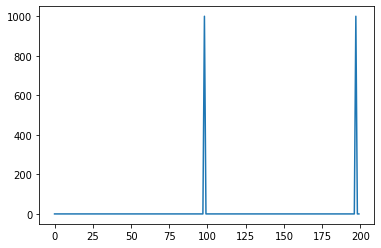

In [4]:
plt.plot(ngo_sim.data[n_probe])

Whichever neuron you choose, after executing the network and plotting the spikes, you will see that the spikes are of amplitude `1/dt = 1000.0` in each case.

# Probing neurons in a NengoDL network

## Training and Evaluating TF network

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
# input
inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

max_pool = tf.keras.layers.MaxPool2D()(conv0)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(max_pool)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10, activation="softmax")(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
_________________________________________________________

In [8]:
model.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=[tf.metrics.sparse_categorical_accuracy])
model.fit(train_images, train_labels, epochs=4)

Epoch 1/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.9413
Epoch 2/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0739 - sparse_categorical_accuracy: 0.9779
Epoch 3/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9817
Epoch 4/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9846


In [9]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9818


[0.06150761619210243, 0.9818000197410583]

## Converting to NengoDL Network

In [10]:
n_steps, sfr = 40, 100

ndl_model = nengo_dl.Converter(
  model,
  swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
  scale_firing_rates=sfr,
  synapse=0.005
)

with ndl_model.net:
  nengo_dl.configure_settings(stateful=False)
  
  # Probe Conv0 layer.
  # Probing ndl_model.layers[conv0].ensemble.neurons is same as Probing ndl_model.layers[conv0]
  conv0_lyr_otpt = nengo.Probe(ndl_model.layers[conv0].ensemble.neurons, attr="output", synapse=None)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:326: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  % (error_msg + ". " if error_msg else "")
/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2ac9ce581200> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [11]:
ndl_test_images = np.tile(
  test_images.reshape((test_images.shape[0], 1, -1)), (1, n_steps, 1))
ndl_input = ndl_model.inputs[inp]
ndl_output = ndl_model.outputs[dense]

In [12]:
with nengo_dl.Simulator(
  ndl_model.net, minibatch_size=100) as ndl_sim:
  data1 = ndl_sim.predict({ndl_input: ndl_test_images[:200]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


### Accuracy over first 200 test images

In [13]:
acc = 0
for pred, true in zip(data1[ndl_output][:, -1, :], test_labels):
  if np.argmax(pred) == true:
    acc += 1
print(acc/200)

0.965


### Investigating raw output from Conv0 layer before multiplying with `sfr` and `dt`.

In [14]:
conv0_otpt = data1[conv0_lyr_otpt]
conv0_otpt.shape

(200, 40, 21632)

In [15]:
b = 0
for neuron in range(conv0_otpt.shape[-1]):
  if np.any(conv0_otpt[0, :, neuron]):
    print(conv0_otpt[0, :, neuron])
    b+=1
  if b == 5: # Print only 5 neurons whose activity is non-zero in any timestep.
    break

[9.999999 0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.      ]
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       9.999999 0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.      ]
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       9.999999 0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.

### Spikes from Conv0 layer after multiplying with `sfr` and `dt`

The output is the number of spikes in a timestep. Here it appears to be `0.99999` i.e. `1` spike per timestep.

In [16]:
conv0_spikes_matrix = data1[conv0_lyr_otpt] * sfr * 0.001 # dt = 0.001

In [17]:
b = 0
for neuron in range(conv0_spikes_matrix.shape[-1]):
  if np.any(conv0_spikes_matrix[0, :, neuron]):
    print(conv0_spikes_matrix[0, :, neuron])
    b+=1
  if b == 5: # Print only 5 neurons whose activity is non-zero in any timestep.
    break

[0.99999994 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99999994 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99999994 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         